In [1]:
### This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

!pip install tqdm boto3 requests regex sentencepiece sacremoses

/kaggle/input/social-media-sentiments-analysis-dataset/sentimentdataset.csv


In [2]:
df = pd.read_csv('/kaggle/input/social-media-sentiments-analysis-dataset/sentimentdataset.csv')

# 1) Exploratory Data Analysis

In [3]:
''' This dataset of sentiment comes from various social media platforms, just like the 
    "about dataset" section stated. With that said there should be plenty of things to explore. '''

df.head()

,Unnamed: 0.1,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,0,0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,1,1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,2,2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,3,3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,4,4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19


### 1.2) Sentiment column/feature

In [4]:
# How many different values are in the sentiment column?
df['Sentiment'].value_counts()

Sentiment
 Positive           44
 Joy                42
 Excitement         32
 Neutral            14
 Contentment        14
                    ..
 Adrenaline          1
 Harmony             1
 ArtisticBurst       1
 Radiance            1
 Elegance            1
Name: count, Length: 279, dtype: int64

In [5]:
''' Interesting result. With that said, in order to build a model that can properly PREDICT, the dataset 
    should only deal with a handful of labels. This one has 279. This will be dealt with later. '''
len(df['Sentiment'].value_counts())

279

### 1.3) Dropping columns

In [6]:
# The first two columns don't seem to have any relevant data, so get rid of them.
first_col = df.columns[0]
second_col = df.columns[1]

print(df[first_col].value_counts())
print('\n')
print(df[second_col].value_counts())

Unnamed: 0.1
0      1
482    1
484    1
485    1
486    1
      ..
246    1
247    1
248    1
249    1
732    1
Name: count, Length: 732, dtype: int64


Unnamed: 0
0      1
486    1
488    1
489    1
490    1
      ..
250    1
251    1
252    1
253    1
736    1
Name: count, Length: 732, dtype: int64


In [7]:
df.drop(first_col, axis=1, inplace=True)
df.drop(second_col, axis=1, inplace=True)

df.head()

,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19


### 1.4) Platforms

In [8]:
# Obviously various social media sites exist. Let's see in detail the platforms the sentiment comes from.
df['Platform'].value_counts()

Platform
 Instagram     258
 Facebook      231
 Twitter       128
 Twitter       115
Name: count, dtype: int64

In [9]:
# Get all values to add the last two since they're both from Twitter.
sentiment_count = df['Platform'].value_counts().to_list()

# Save the combined twitter value.
updated_twitter_count = sentiment_count[2] + sentiment_count[3]

# Get rid of last 2 with .pop and then append new value
sentiment_count.pop()
sentiment_count.pop()
sentiment_count.append(updated_twitter_count)

# Display values
sentiment_count

[258, 231, 243]

In [10]:
''' Visually speaking, this is why there's "two" Twitters. Because index 0 below shows more spaces
    whilst index 3 shows about 1. '''
df['Platform'].unique()

array([' Twitter  ', ' Instagram ', ' Facebook ', ' Twitter '],
      dtype=object)

In [11]:
df.head()

,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19


In [12]:
''' In order to make sure the "Platform" column values are the same, let's map a function to it.
    Simple lambda function. "x" will be each individual platform string and ".strip" is used to 
    remove white spaces in the beginning and end of the string as seen the first time 
    "df['Platform'].unique()" was used earlier. '''

df['Platform'] = df['Platform'].map(lambda x: x.strip())

df.head()

,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19


In [13]:
# NOW we can clearly see only 3 platforms now. Great.
df['Platform'].unique()

array(['Twitter', 'Instagram', 'Facebook'], dtype=object)

<Axes: ylabel='count'>

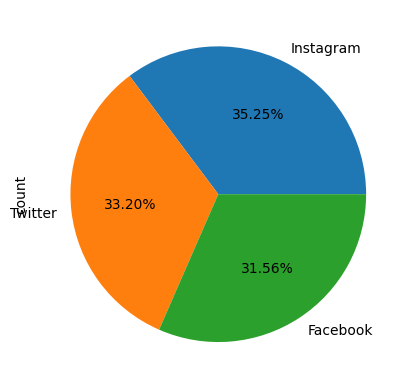

In [14]:
# Same range as shown below.
df['Platform'].value_counts().plot(kind='pie', autopct='%1.2f%%')

### 1.5) Country

In [15]:
df.head()

,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19


In [16]:
''' "Apparently" there's 151 countries in the dataset but the exact same issue with the platform 
    column is present. Seen below USA is shown twice. '''
df['Country'].value_counts()

Country
 USA               59
 USA               55
 UK                49
 Canada            44
 Australia         41
                   ..
 Netherlands        1
 USA                1
 Germany            1
 France             1
 USA                1
Name: count, Length: 115, dtype: int64

In [17]:
# Showing the unique values definitely shows obvious repeats that should be handled just like the Platform column.
df['Country'].unique()

array([' USA      ', ' Canada   ', ' USA        ', ' UK       ',
       ' Australia ', ' India    ', ' USA    ', 'USA', ' Canada    ',
       ' USA       ', ' USA ', ' Canada  ', ' UK ', ' India     ',
       ' Canada ', ' UK        ', ' India ', ' UK   ', ' UK         ',
       ' USA     ', ' Canada     ', ' USA          ', ' India      ',
       ' Australia  ', ' UK           ', ' Canada       ',
       ' Australia   ', ' Australia    ', ' UK            ', ' USA   ',
       ' India       ', ' UK          ', ' USA  ', ' UK      ',
       ' Canada      ', ' India   ', ' Canada          ',
       ' India        ', ' Australia     ', ' Canada        ',
       ' India         ', ' USA           ', ' USA               ',
       ' Canada            ', ' UK                ',
       ' India              ', ' Australia          ',
       ' France            ', ' Brazil            ',
       ' Japan             ', ' Greece            ',
       ' India             ', ' Brazil           ', ' Franc

In [18]:
df['Country'] = df['Country'].map(lambda x: x.strip())

# Much better and sensible. Only 33 countries.
print(df['Country'].unique())
print('\n')
print(len(df['Country'].unique()))

['USA' 'Canada' 'UK' 'Australia' 'India' 'France' 'Brazil' 'Japan'
 'Greece' 'Germany' 'Sweden' 'Italy' 'Netherlands' 'South Africa' 'Spain'
 'Portugal' 'Switzerland' 'Austria' 'Belgium' 'Denmark' 'Czech Republic'
 'Jordan' 'Peru' 'Maldives' 'China' 'Cambodia' 'Norway' 'Colombia'
 'Ireland' 'Jamaica' 'Kenya' 'Scotland' 'Thailand']


33


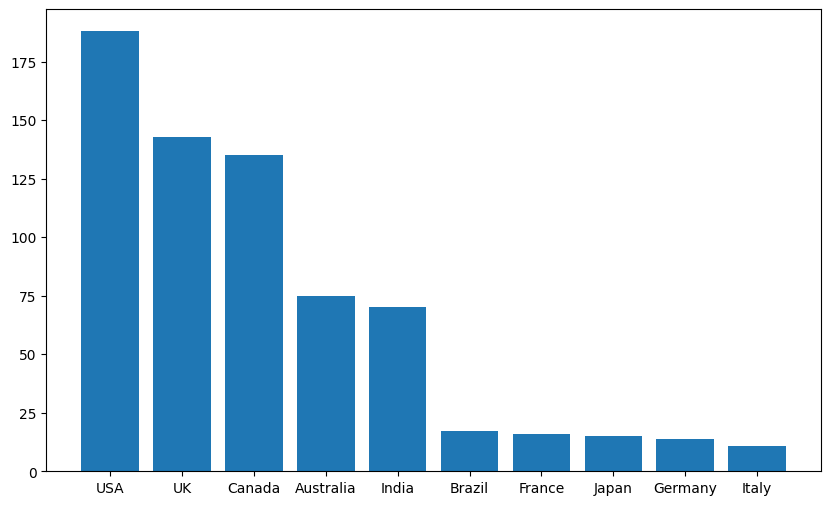

In [19]:
import matplotlib.pyplot as plt

''' .value_counts() returns # of each value present and .index gets the categorical value column 
    like "USA", "UK" etc. Then "tolist()" just gets the numbers assigned to each country. 
    sent_per_country = sentiment per country. Since there's so many coutries, only display the
    first 10. '''
country_names = df['Country'].value_counts().index[:10]

sent_per_country = df['Country'].value_counts().tolist()[:10]

plt.figure(figsize=(10, 6))
plt.bar(country_names, sent_per_country)
plt.show()

### 1.6) Text

In [20]:
''' The exact same weird spacing issue with the text like the Country column. Solve here. Display
    a few social media posts before and after the process. '''

print(df['Text'][:3])
print('\n')

df['Text'] = df['Text'].apply(lambda x: x.strip())
print(df['Text'][:3])

0     Enjoying a beautiful day at the park!        ...
1     Traffic was terrible this morning.           ...
2     Just finished an amazing workout! 💪          ...
Name: Text, dtype: object


0    Enjoying a beautiful day at the park!
1       Traffic was terrible this morning.
2      Just finished an amazing workout! 💪
Name: Text, dtype: object


### 1.7) Year

In [21]:
# Just curious as to how old certain social media posts were made.
sorted_posts = df['Year'].value_counts().sort_index()

sorted_posts

Year
2010      3
2011      4
2012      4
2013      4
2014      4
2015     19
2016     38
2017     43
2018     56
2019     73
2020     69
2021     63
2022     63
2023    289
Name: count, dtype: int64

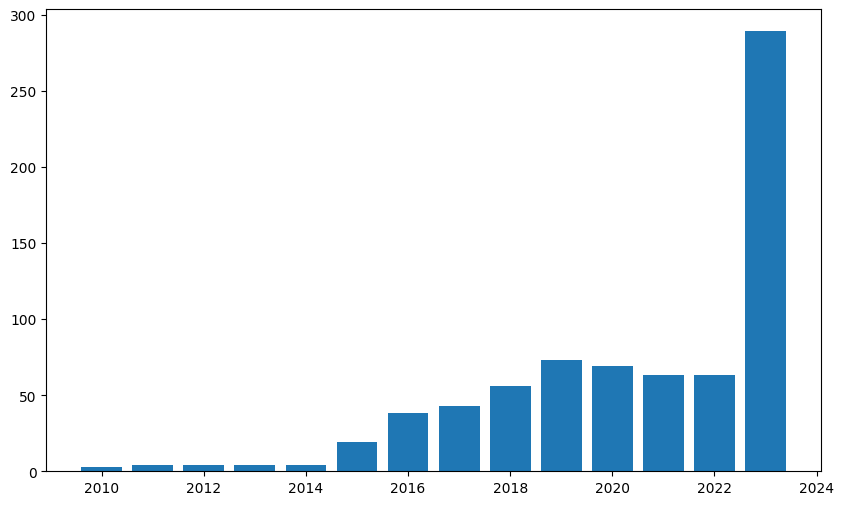

In [22]:
# Get the years index from the above series and get sorted values to match and plot.
sorted_years = sorted_posts.index
posts_each_year = df['Year'].value_counts().sort_index().tolist()

plt.figure(figsize=(10, 6))
plt.bar(sorted_years, posts_each_year)
plt.show()

### 1.8) Revisiting the "Sentiment" column for same issue

In [23]:
''' It's clear that spacing issues in the categorical/string columns didn't tell the 
    proper story when looking at unique values. With that said, only reasonable to at
    least CHECK the Sentiment column. '''

df['Sentiment'].unique()

array([' Positive  ', ' Negative  ', ' Neutral   ', ' Anger        ',
       ' Fear         ', ' Sadness      ', ' Disgust      ',
       ' Happiness    ', ' Joy          ', ' Love         ',
       ' Amusement    ', ' Enjoyment    ', ' Admiration   ',
       ' Affection    ', ' Awe          ', ' Disappointed ',
       ' Surprise     ', ' Acceptance   ', ' Adoration    ',
       ' Anticipation ', ' Bitter       ', ' Calmness     ',
       ' Confusion    ', ' Excitement   ', ' Kind         ',
       ' Pride        ', ' Shame        ', ' Confusion ', ' Excitement ',
       ' Shame ', ' Elation       ', ' Euphoria      ', ' Contentment   ',
       ' Serenity      ', ' Gratitude     ', ' Hope          ',
       ' Empowerment   ', ' Compassion    ', ' Tenderness    ',
       ' Arousal       ', ' Enthusiasm    ', ' Fulfillment  ',
       ' Reverence     ', ' Compassion', ' Fulfillment   ', ' Reverence ',
       ' Elation   ', ' Despair         ', ' Grief           ',
       ' Loneliness     

In [24]:
len(df['Sentiment'].unique())

279

In [25]:
''' Picking out random ones like "Joy", and doing control + F on the keyboard showed that the word
    "Joy" is shown twice. "Surprise" is shown 3 times. So the same issue is going on here as well.
    From 279 unique values in the "Sentiment" column, to 191. Great. '''

df['Sentiment'] = df['Sentiment'].map(lambda x: x.strip())


print(df.head())
print('\n\n')
print(df['Sentiment'].unique())
print('\n\n')
print(len(df['Sentiment'].unique()))

                                          Text Sentiment            Timestamp  \
0        Enjoying a beautiful day at the park!  Positive  2023-01-15 12:30:00   
1           Traffic was terrible this morning.  Negative  2023-01-15 08:45:00   
2          Just finished an amazing workout! 💪  Positive  2023-01-15 15:45:00   
3  Excited about the upcoming weekend getaway!  Positive  2023-01-15 18:20:00   
4  Trying out a new recipe for dinner tonight.   Neutral  2023-01-15 19:55:00   

             User   Platform                                    Hashtags  \
0   User123          Twitter   #Nature #Park                               
1   CommuterX        Twitter   #Traffic #Morning                           
2   FitnessFan     Instagram   #Fitness #Workout                           
3   AdventureX      Facebook   #Travel #Adventure                          
4   ChefCook       Instagram   #Cooking #Food                              

   Retweets  Likes    Country  Year  Month  Day  Hour  


In [26]:
df.head()

,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,Enjoying a beautiful day at the park!,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,Traffic was terrible this morning.,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,Just finished an amazing workout! 💪,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,Excited about the upcoming weekend getaway!,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,Trying out a new recipe for dinner tonight.,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19


# 2) Adjusting "Sentiment" column

In [27]:
''' A comment I made in section 1.2 stated that the amount of labels were way too many. Here,
    that issue will be dealt with.What I'm thinking is, there are a lot of words in the Sentiment 
    column that seem like synonyms such as the words "Positive", "Joy", "Excitement", "Contentment".
    Also for the record, the definition of Contentment according to Google is "a state of happiness
    and satisfaction.". Sounds pretty positive to me. What about negative words? Well there's 
    "Anger", "Fear", "Sadness", "Disgust", "Jealously", and more. It's WORTH trying to group the 
    similar sentiments together under one sentiment and go from there. '''

# cdf = copy dataframe
cdf = df.copy()

cdf.head()

,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,Enjoying a beautiful day at the park!,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,Traffic was terrible this morning.,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,Just finished an amazing workout! 💪,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,Excited about the upcoming weekend getaway!,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,Trying out a new recipe for dinner tonight.,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19


In [28]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

''' The nltk SentimentIntensityAnalyzer uses it's "polarity_scores" function to check if a word
    is either positive, negative or neutral. When given a word, it returns a dictionary with those
    values (as well as "compound") in a dictionary. The positive, negative, and neutral scores 
    always add up to 1 and won't be negative. However the compound can range from -1 to 1. If
    compound score is more negative, likely the text itself is negative. Vice versa, it's more 
    positive. '''

sia = SentimentIntensityAnalyzer()

sia.polarity_scores("Happy")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.5719}

In [29]:
# Get the sentiment column as a list to use with the SentimentIntensityAnalyzer object.
all_sentiment_words = cdf['Sentiment'].unique().tolist()

### 2.2) Identifying positive, negative, and neutral words.

In [30]:
pos_words = []
neg_words = []
neu_words = []

for word in all_sentiment_words:
    # Get compound score of the word.
    score = sia.polarity_scores(word)['compound']
    
    ''' There's really no "defined" range to ALWAYS use. This is best done by experimentation. Even afterwards,
        if tweaking the results in the lists helps, why not do that as well. For example, when the score value
        was 0.50 & -0.50, the word "Excitement" was listed in "Neutral". But I changed them both to 0.40 & -0.40,
        and "Excitement" was then listed in the "Positive" list. Going even further, the word "Embarrassed" was
        in the "Neutral" list with 0.40 & -0.40. Changing the values to 0.35 & -0.35 switched the word to be
        in the "Negative" list.
        
        Of course, if a condition is met below, add to the appropriate list. The results aren't too bad. '''
    if score >= 0.35:
        pos_words.append(word)
    elif score <= -0.35:
        neg_words.append(word)
    else:
        neu_words.append(word)
        
print(f'Positive words:\n{pos_words}\n\nNegative words:\n{neg_words}\n\nNeutral words:\n{neu_words}\n')
print(f'Pos len: {len(pos_words)}\nNeg len: {len(neg_words)}\nNeu len: {len(neu_words)}')

Positive words:
['Positive', 'Happiness', 'Joy', 'Love', 'Amusement', 'Enjoyment', 'Admiration', 'Affection', 'Acceptance', 'Adoration', 'Calmness', 'Excitement', 'Kind', 'Elation', 'Euphoria', 'Contentment', 'Gratitude', 'Hope', 'Compassion', 'Tenderness', 'Enthusiasm', 'Determination', 'Hopeful', 'Proud', 'Grateful', 'Empathetic', 'Compassionate', 'Playful', 'Inspired', 'Confident', 'Thrill', 'Overjoyed', 'Inspiration', 'Satisfaction', 'Blessed', 'Appreciation', 'Confidence', 'Optimism', 'Elegance', 'Harmony', 'Creativity', 'Coziness', 'Freedom', 'Marvel', 'Positivity', 'Kindness', 'Friendship', 'Success', 'Amazement', 'Romance', 'Tranquility', 'Grandeur', 'Charm', 'Ecstasy', 'Engagement', 'Triumph', 'Heartwarming', 'Sympathy', 'Joy in Baking', 'Thrilling Journey', "Nature's Beauty", 'Creative Inspiration', 'Runway Creativity', "Ocean's Freedom", 'Relief', 'Happy']

Negative words:
['Negative', 'Anger', 'Fear', 'Sadness', 'Disgust', 'Disappointed', 'Bitter', 'Shame', 'Grief', 'Loneli

In [31]:
''' Results are good, but maybe a bit of tweaking can be good. Ex: the word "Jealously" is in neutral which is a bit strange given 
    that the root word "Jealous" is rightfully in the negative word list. So some adjustments can be made. I've picked out
    several words that are in Neutral at the moment but arguably should belong in pos or neg. '''

neg_words_to_move = ['Despair', 'Jealousy', 'Anxiety', 'Envious', 'Darkness', 'Desolation', 'Loss', 'Heartache']

pos_words_to_move = ['Fulfillment', 'Motivation', 'JoyfulReunion', 'Accomplishment', 'Wonderment', 'Enchantment', 
                     'PlayfulJoy', 'FestiveJoy', 'Celebration']

for neg_word in neg_words_to_move:
    # While looping, get the index of the current word and delete it from neutral words list.
    index = neu_words.index(neg_word)
    del neu_words[index]

print(f'Neutral words:\n{neu_words}\n\nNeutral words length: {len(neu_words)}')

Neutral words:
['Neutral', 'Awe', 'Surprise', 'Anticipation', 'Confusion', 'Pride', 'Serenity', 'Empowerment', 'Arousal', 'Fulfillment', 'Reverence', 'Boredom', 'Envy', 'Curiosity', 'Indifference', 'Numbness', 'Nostalgia', 'Ambivalence', 'Zest', 'Free-spirited', 'Yearning', 'Apprehensive', 'Overwhelmed', 'Dismissive', 'Bittersweet', 'Motivation', 'Contemplation', 'JoyfulReunion', 'Reflection', 'Accomplishment', 'Wonderment', 'Enchantment', 'Intrigue', 'PlayfulJoy', 'Mindfulness', 'DreamChaser', 'Whimsy', 'Pensive', 'Radiance', 'Wonder', 'Rejuvenation', 'Adventure', 'Melodic', 'FestiveJoy', 'InnerJourney', 'Dazzle', 'Adrenaline', 'ArtisticBurst', 'CulinaryOdyssey', 'Resilience', 'Immersion', 'Spark', 'EmotionalStorm', 'LostLove', 'Solitude', 'Exploration', 'Captivation', 'Emotion', 'Energy', 'Celebration', 'Colorful', 'Hypnotic', 'Connection', 'Iconic', 'Journey', 'Touched', 'Suspense', 'Pressure', 'Renewed Effort', 'Miscalculation', 'Challenge', 'Solace', 'Breakthrough', 'Envisioning H

In [32]:
# Same process for positive words that are in the neu_words list
for pos_word in pos_words_to_move:
    index = neu_words.index(pos_word)
    del neu_words[index]

''' Notice how the neu_words list gets smaller by the amount of words in both pos/neg_words_to_remove, 
    to confirm things are working fine.'''
print(f'Neutral words:\n{neu_words}\n\nNeutral words length: {len(neu_words)}')

Neutral words:
['Neutral', 'Awe', 'Surprise', 'Anticipation', 'Confusion', 'Pride', 'Serenity', 'Empowerment', 'Arousal', 'Reverence', 'Boredom', 'Envy', 'Curiosity', 'Indifference', 'Numbness', 'Nostalgia', 'Ambivalence', 'Zest', 'Free-spirited', 'Yearning', 'Apprehensive', 'Overwhelmed', 'Dismissive', 'Bittersweet', 'Contemplation', 'Reflection', 'Intrigue', 'Mindfulness', 'DreamChaser', 'Whimsy', 'Pensive', 'Radiance', 'Wonder', 'Rejuvenation', 'Adventure', 'Melodic', 'InnerJourney', 'Dazzle', 'Adrenaline', 'ArtisticBurst', 'CulinaryOdyssey', 'Resilience', 'Immersion', 'Spark', 'EmotionalStorm', 'LostLove', 'Solitude', 'Exploration', 'Captivation', 'Emotion', 'Energy', 'Colorful', 'Hypnotic', 'Connection', 'Iconic', 'Journey', 'Touched', 'Suspense', 'Pressure', 'Renewed Effort', 'Miscalculation', 'Challenge', 'Solace', 'Breakthrough', 'Envisioning History', 'Imagination', 'Vibrancy', 'Mesmerizing', 'Culinary Adventure', 'Winter Magic', 'Celestial Wonder', 'Whispers of the Past', 'Mi

In [33]:
# Can't forget to add these pos and neg words to their appropriate new lists.
for word in pos_words_to_move:
    pos_words.append(word)

for word in neg_words_to_move:
    neg_words.append(word)
    
print(f'Pos words:\n{pos_words}\nPos words length: {len(pos_words)}\n\n')
print(f'Neg words:\n{neg_words}\nNeg words length: {len(neg_words)}')

Pos words:
['Positive', 'Happiness', 'Joy', 'Love', 'Amusement', 'Enjoyment', 'Admiration', 'Affection', 'Acceptance', 'Adoration', 'Calmness', 'Excitement', 'Kind', 'Elation', 'Euphoria', 'Contentment', 'Gratitude', 'Hope', 'Compassion', 'Tenderness', 'Enthusiasm', 'Determination', 'Hopeful', 'Proud', 'Grateful', 'Empathetic', 'Compassionate', 'Playful', 'Inspired', 'Confident', 'Thrill', 'Overjoyed', 'Inspiration', 'Satisfaction', 'Blessed', 'Appreciation', 'Confidence', 'Optimism', 'Elegance', 'Harmony', 'Creativity', 'Coziness', 'Freedom', 'Marvel', 'Positivity', 'Kindness', 'Friendship', 'Success', 'Amazement', 'Romance', 'Tranquility', 'Grandeur', 'Charm', 'Ecstasy', 'Engagement', 'Triumph', 'Heartwarming', 'Sympathy', 'Joy in Baking', 'Thrilling Journey', "Nature's Beauty", 'Creative Inspiration', 'Runway Creativity', "Ocean's Freedom", 'Relief', 'Happy', 'Fulfillment', 'Motivation', 'JoyfulReunion', 'Accomplishment', 'Wonderment', 'Enchantment', 'PlayfulJoy', 'FestiveJoy', 'Cel

### 2.3) Applying identified words to dataframe

In [34]:
cdf['Sentiment'].value_counts()

Sentiment
Positive          45
Joy               44
Excitement        37
Contentment       19
Neutral           18
                  ..
LostLove           1
EmotionalStorm     1
Suffering          1
Bittersweet        1
Intrigue           1
Name: count, Length: 191, dtype: int64

In [35]:
''' To test that this process works, I'll display a certain range in the copied dataframe in this cell.
    Some values in the "Sentiment" column are of course in the "pos_words" list such as:
    Euphoria, Euphoria, Gratitude, Hope, Compassion, Tenderness, Enthusiam, Fulfillment, and elation.
    See below for confirmation. '''
cdf[150:165]

,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
150,The euphoria of a successful product launch.,Euphoria,2022-04-03 11:45:00,ProductLaunchJoy,Facebook,#Euphoria #ProductLaunchSuccess,15.0,30.0,USA,2022,4,3,11
151,Contentment in the embrace of a loved one.,Contentment,2010-11-12 20:20:00,LovingEmbrace,Twitter,#Contentment #Love,30.0,60.0,India,2010,11,12,20
152,Serenity found in the beauty of a sunset by th...,Serenity,2011-07-22 18:30:00,SunsetWatcher2,Instagram,#Serenity #SunsetViews,22.0,45.0,Canada,2011,7,22,18
153,Gratitude for the small joys that each day bri...,Gratitude,2012-03-30 11:20:00,JoyfulHeart2,Facebook,#Gratitude #SmallJoys,15.0,30.0,Australia,2012,3,30,11
154,Hopeful about the potential for personal growth.,Hope,2013-10-05 16:40:00,GrowthOptimist,Twitter,#Hope #PersonalDevelopment,18.0,35.0,UK,2013,10,5,16
155,Empowerment through learning a new skill.,Empowerment,2014-07-10 13:15:00,SkillEmpower,Instagram,#Empowerment #SkillBuilding,25.0,50.0,India,2014,7,10,13
156,Compassion in volunteering for a local charity.,Compassion,2015-12-18 14:20:00,CharityVolunteer,Facebook,#Compassion #VolunteerWork,18.0,35.0,USA,2015,12,18,14
157,Tenderness in a quiet moment shared with a pet.,Tenderness,2016-02-10 19:45:00,PetLove,Twitter,#Tenderness #PetLove,25.0,50.0,Canada,2016,2,10,19
158,Arousal of excitement for an upcoming festival.,Arousal,2017-09-25 11:30:00,FestivalFan,Instagram,#Arousal #FestivalExcitement,20.0,40.0,UK,2017,9,25,11
159,Enthusiasm for a DIY home improvement project.,Enthusiasm,2018-04-15 16:00:00,DIYEnthusiast,Facebook,#Enthusiasm #HomeImprovement,15.0,30.0,Australia,2018,4,15,16


In [36]:
# Check every value in sentiment column, if the string is in pos_words, replace it with positive. Otherwise, just return it.
cdf['Sentiment'] = cdf['Sentiment'].map(lambda x: "Positive" if x in pos_words else x)

In [37]:
print(f'Pos words:\n{pos_words}\n\n')

''' Check the exact same range again and compare and contrast with the pos words shown yet again. REMEMBER, 
    I stated before the positive words in this section would be:
    "Euphoria, Euphoria, Gratitude, Hope, Compassion, Tenderness, Enthusiam, Fulfillment, and Elation."
    Each of these were previously in the dataframe, now they've been replaced. Next cell will do
    the same for negative words. '''
cdf[150:165]

Pos words:
['Positive', 'Happiness', 'Joy', 'Love', 'Amusement', 'Enjoyment', 'Admiration', 'Affection', 'Acceptance', 'Adoration', 'Calmness', 'Excitement', 'Kind', 'Elation', 'Euphoria', 'Contentment', 'Gratitude', 'Hope', 'Compassion', 'Tenderness', 'Enthusiasm', 'Determination', 'Hopeful', 'Proud', 'Grateful', 'Empathetic', 'Compassionate', 'Playful', 'Inspired', 'Confident', 'Thrill', 'Overjoyed', 'Inspiration', 'Satisfaction', 'Blessed', 'Appreciation', 'Confidence', 'Optimism', 'Elegance', 'Harmony', 'Creativity', 'Coziness', 'Freedom', 'Marvel', 'Positivity', 'Kindness', 'Friendship', 'Success', 'Amazement', 'Romance', 'Tranquility', 'Grandeur', 'Charm', 'Ecstasy', 'Engagement', 'Triumph', 'Heartwarming', 'Sympathy', 'Joy in Baking', 'Thrilling Journey', "Nature's Beauty", 'Creative Inspiration', 'Runway Creativity', "Ocean's Freedom", 'Relief', 'Happy', 'Fulfillment', 'Motivation', 'JoyfulReunion', 'Accomplishment', 'Wonderment', 'Enchantment', 'PlayfulJoy', 'FestiveJoy', 'Cel

,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
150,The euphoria of a successful product launch.,Positive,2022-04-03 11:45:00,ProductLaunchJoy,Facebook,#Euphoria #ProductLaunchSuccess,15.0,30.0,USA,2022,4,3,11
151,Contentment in the embrace of a loved one.,Positive,2010-11-12 20:20:00,LovingEmbrace,Twitter,#Contentment #Love,30.0,60.0,India,2010,11,12,20
152,Serenity found in the beauty of a sunset by th...,Serenity,2011-07-22 18:30:00,SunsetWatcher2,Instagram,#Serenity #SunsetViews,22.0,45.0,Canada,2011,7,22,18
153,Gratitude for the small joys that each day bri...,Positive,2012-03-30 11:20:00,JoyfulHeart2,Facebook,#Gratitude #SmallJoys,15.0,30.0,Australia,2012,3,30,11
154,Hopeful about the potential for personal growth.,Positive,2013-10-05 16:40:00,GrowthOptimist,Twitter,#Hope #PersonalDevelopment,18.0,35.0,UK,2013,10,5,16
155,Empowerment through learning a new skill.,Empowerment,2014-07-10 13:15:00,SkillEmpower,Instagram,#Empowerment #SkillBuilding,25.0,50.0,India,2014,7,10,13
156,Compassion in volunteering for a local charity.,Positive,2015-12-18 14:20:00,CharityVolunteer,Facebook,#Compassion #VolunteerWork,18.0,35.0,USA,2015,12,18,14
157,Tenderness in a quiet moment shared with a pet.,Positive,2016-02-10 19:45:00,PetLove,Twitter,#Tenderness #PetLove,25.0,50.0,Canada,2016,2,10,19
158,Arousal of excitement for an upcoming festival.,Arousal,2017-09-25 11:30:00,FestivalFan,Instagram,#Arousal #FestivalExcitement,20.0,40.0,UK,2017,9,25,11
159,Enthusiasm for a DIY home improvement project.,Positive,2018-04-15 16:00:00,DIYEnthusiast,Facebook,#Enthusiasm #HomeImprovement,15.0,30.0,Australia,2018,4,15,16


In [38]:
print(f'Neg words:{neg_words}\n')

cdf['Sentiment'] = cdf['Sentiment'].map(lambda x: "Negative" if x in neg_words else x)

# Only the bottom 2 were changed here.
cdf[150:165]

Neg words:['Negative', 'Anger', 'Fear', 'Sadness', 'Disgust', 'Disappointed', 'Bitter', 'Shame', 'Grief', 'Loneliness', 'Resentment', 'Frustration', 'Intimidation', 'Helplessness', 'Regret', 'Melancholy', 'Bitterness', 'Fearful', 'Jealous', 'Devastated', 'Frustrated', 'Heartbreak', 'Betrayal', 'Suffering', 'Isolation', 'Disappointment', 'Exhaustion', 'Sorrow', 'Desperation', 'Ruins', 'Obstacle', 'Embarrassed', 'Sad', 'Hate', 'Bad', 'Despair', 'Jealousy', 'Anxiety', 'Envious', 'Darkness', 'Desolation', 'Loss', 'Heartache']



,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
150,The euphoria of a successful product launch.,Positive,2022-04-03 11:45:00,ProductLaunchJoy,Facebook,#Euphoria #ProductLaunchSuccess,15.0,30.0,USA,2022,4,3,11
151,Contentment in the embrace of a loved one.,Positive,2010-11-12 20:20:00,LovingEmbrace,Twitter,#Contentment #Love,30.0,60.0,India,2010,11,12,20
152,Serenity found in the beauty of a sunset by th...,Serenity,2011-07-22 18:30:00,SunsetWatcher2,Instagram,#Serenity #SunsetViews,22.0,45.0,Canada,2011,7,22,18
153,Gratitude for the small joys that each day bri...,Positive,2012-03-30 11:20:00,JoyfulHeart2,Facebook,#Gratitude #SmallJoys,15.0,30.0,Australia,2012,3,30,11
154,Hopeful about the potential for personal growth.,Positive,2013-10-05 16:40:00,GrowthOptimist,Twitter,#Hope #PersonalDevelopment,18.0,35.0,UK,2013,10,5,16
155,Empowerment through learning a new skill.,Empowerment,2014-07-10 13:15:00,SkillEmpower,Instagram,#Empowerment #SkillBuilding,25.0,50.0,India,2014,7,10,13
156,Compassion in volunteering for a local charity.,Positive,2015-12-18 14:20:00,CharityVolunteer,Facebook,#Compassion #VolunteerWork,18.0,35.0,USA,2015,12,18,14
157,Tenderness in a quiet moment shared with a pet.,Positive,2016-02-10 19:45:00,PetLove,Twitter,#Tenderness #PetLove,25.0,50.0,Canada,2016,2,10,19
158,Arousal of excitement for an upcoming festival.,Arousal,2017-09-25 11:30:00,FestivalFan,Instagram,#Arousal #FestivalExcitement,20.0,40.0,UK,2017,9,25,11
159,Enthusiasm for a DIY home improvement project.,Positive,2018-04-15 16:00:00,DIYEnthusiast,Facebook,#Enthusiasm #HomeImprovement,15.0,30.0,Australia,2018,4,15,16


In [39]:
# Finally, neutral.
cdf['Sentiment'] = cdf['Sentiment'].map(lambda x: "Neutral" if x in neu_words else x)

cdf[150:165]

,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
150,The euphoria of a successful product launch.,Positive,2022-04-03 11:45:00,ProductLaunchJoy,Facebook,#Euphoria #ProductLaunchSuccess,15.0,30.0,USA,2022,4,3,11
151,Contentment in the embrace of a loved one.,Positive,2010-11-12 20:20:00,LovingEmbrace,Twitter,#Contentment #Love,30.0,60.0,India,2010,11,12,20
152,Serenity found in the beauty of a sunset by th...,Neutral,2011-07-22 18:30:00,SunsetWatcher2,Instagram,#Serenity #SunsetViews,22.0,45.0,Canada,2011,7,22,18
153,Gratitude for the small joys that each day bri...,Positive,2012-03-30 11:20:00,JoyfulHeart2,Facebook,#Gratitude #SmallJoys,15.0,30.0,Australia,2012,3,30,11
154,Hopeful about the potential for personal growth.,Positive,2013-10-05 16:40:00,GrowthOptimist,Twitter,#Hope #PersonalDevelopment,18.0,35.0,UK,2013,10,5,16
155,Empowerment through learning a new skill.,Neutral,2014-07-10 13:15:00,SkillEmpower,Instagram,#Empowerment #SkillBuilding,25.0,50.0,India,2014,7,10,13
156,Compassion in volunteering for a local charity.,Positive,2015-12-18 14:20:00,CharityVolunteer,Facebook,#Compassion #VolunteerWork,18.0,35.0,USA,2015,12,18,14
157,Tenderness in a quiet moment shared with a pet.,Positive,2016-02-10 19:45:00,PetLove,Twitter,#Tenderness #PetLove,25.0,50.0,Canada,2016,2,10,19
158,Arousal of excitement for an upcoming festival.,Neutral,2017-09-25 11:30:00,FestivalFan,Instagram,#Arousal #FestivalExcitement,20.0,40.0,UK,2017,9,25,11
159,Enthusiasm for a DIY home improvement project.,Positive,2018-04-15 16:00:00,DIYEnthusiast,Facebook,#Enthusiasm #HomeImprovement,15.0,30.0,Australia,2018,4,15,16


In [40]:
# Much more sensible.
cdf['Sentiment'].value_counts()

Sentiment
Positive    360
Neutral     212
Negative    160
Name: count, dtype: int64

### 2.4) Sentiment column to numerical

In [41]:
# Almost forgot this should be numerical.
num_sentiments = {
    "Positive": 0,
    "Negative": 1,
    "Neutral": 2
}

# Display before and after.
print(cdf.head())
print('\n')

cdf['Sentiment'] = cdf['Sentiment'].replace(num_sentiments)


cdf.head()

                                          Text Sentiment            Timestamp  \
0        Enjoying a beautiful day at the park!  Positive  2023-01-15 12:30:00   
1           Traffic was terrible this morning.  Negative  2023-01-15 08:45:00   
2          Just finished an amazing workout! 💪  Positive  2023-01-15 15:45:00   
3  Excited about the upcoming weekend getaway!  Positive  2023-01-15 18:20:00   
4  Trying out a new recipe for dinner tonight.   Neutral  2023-01-15 19:55:00   

             User   Platform                                    Hashtags  \
0   User123          Twitter   #Nature #Park                               
1   CommuterX        Twitter   #Traffic #Morning                           
2   FitnessFan     Instagram   #Fitness #Workout                           
3   AdventureX      Facebook   #Travel #Adventure                          
4   ChefCook       Instagram   #Cooking #Food                              

   Retweets  Likes    Country  Year  Month  Day  Hour  


,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,Enjoying a beautiful day at the park!,0,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,Traffic was terrible this morning.,1,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,Just finished an amazing workout! 💪,0,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,Excited about the upcoming weekend getaway!,0,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,Trying out a new recipe for dinner tonight.,2,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19


# 3) Tokenization

In [42]:
from transformers import AutoTokenizer, AutoModel, BertTokenizer

In [43]:
''' from_pretrained is used to get the same matching model & tokenizer. Mixing them up 
    is bad because under the hood, they both could work differently '''

chosen_model = 'bert-base-cased'
tk = BertTokenizer.from_pretrained(chosen_model)

In [44]:
test_text = "Superbowl is almost here and I couldn't possibly care less."

''' Using the tokenizer this way gets input_ids which are string to num conversions, 
    and also puts in special tokens like 101, and 102 for us. Then includes the 
    token_type_ids and attention_mask.
    
    Different way to tokenize. Doing "tokenizer_object.tokenizer(text here)" will 
    get us the regular tokenized words. Meaning If we have str "Superbowl is almost 
    here and I couldn't possibly care less." The result will be: ['Super', '##bow', 
    '##l', 'is', 'almost', 'here', 'and', 'I', 'couldn', "'", 't', 'possibly', 'care',
    'less', '.'] which uses sub word based tokenization (a combination of character 
    and word based). However this gets us regular tokens, use convert_tokens_to_ids 
    to get numerical representation SIMILAR to previous cell. The result will NOT 
    have special characters like 101 at the start and 102 at the end.

    Also this 2 step method of "tokenizer_object.tokenizer(text here)" 
    and convert_tokens_to_ids can be simplified with doing "tk(test_text)" above. 
    Because I can access the num conversions with "obj['input_ids']". Also for the 
    record, the tokenizer has other relevant args like:
    1) padding - in a group of sentences, the biggest one won't be changed, but the smaller ones will
        have values added to it.

    2) truncation - Chopping OFF the length from a sentence

    3) return_tensors - Since transformer models only accept tensors as input, can return ones like "pt"
        for pytorch

    And a lot more. '''

x = tk(test_text)

x

{'input_ids': [101, 3198, 14251, 1233, 1110, 1593, 1303, 1105, 146, 1577, 112, 189, 3566, 1920, 1750, 119, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [45]:
''' encode_plus, just like the "tokenizer(text_here, other args)" let's us customize how tokenization
    happens which gives us more power and control regarding how many args it supports. 
    
    Got the warning: "FutureWarning: The `pad_to_max_length` argument is deprecated and will be 
    removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest
    sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, 
    you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length 
    to None to pad to the maximal input size of the model (e.g. 512 for Bert)." 
        
        So seems like I'll have to use padding= instead of pad_to_max_length '''

encoded_values = tk.encode_plus(
    test_text,
    max_length=32,
    add_special_tokens=True,
    return_token_type_ids=False,
    padding='max_length',
    return_attention_mask=True,
    truncation=True,
    return_tensors='pt'
)

encoded_values

{'input_ids': tensor([[  101,  3198, 14251,  1233,  1110,  1593,  1303,  1105,   146,  1577,
           112,   189,  3566,  1920,  1750,   119,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])}

# 4) Dataset

In [46]:
# At this point only the text and label (Sentiment) column matter. Discard the rest
cdf = cdf[['Text', 'Sentiment']]

# Visually seeing the df once again
cdf.head()

,Text,Sentiment
0,Enjoying a beautiful day at the park!,0
1,Traffic was terrible this morning.,1
2,Just finished an amazing workout! 💪,0
3,Excited about the upcoming weekend getaway!,0
4,Trying out a new recipe for dinner tonight.,2


In [47]:
import torch
from torch.utils.data import Dataset

''' Datasets are used in PyTorch a lot to get data in an organized fashion, even iterate over 
    it easily. In some cases, like in image classification, no need to load ALL the images in
    memmory at once, especially if it's a big project. Use the __getitem__ function to load
    upon request.
    
    1) text - The entire text column in above df.
    2) labels - The entire Sentiment column in above df
    3) tokenizer_to_use - Defeats hard coding because if I change and decide to use a different
        tokenizer entirely, it'll be passed in.
    4) chosen_max_len - Max len to apply during tokenization. '''

class SentimentDataset(Dataset):
    def __init__(self, text, labels, tokenizer_to_use, chosen_max_len):
        self.text = text
        self.labels = labels
        self.tokenizer_to_use = tokenizer_to_use
        self.chosen_max_len = chosen_max_len
        
    # Like I stated earler, in __getitem__, simply return an object
    def __getitem__(self, index):
        selected_text = self.text[index]
        selected_label = self.labels[index]
        
        ''' .encode_plus returns type "transformers.tokenization_utils_base.BatchEncoding", hence 
            the name for the variable. I explained encode_plus in a previous cell but to add, I
            enjoy doing anything PyTorch related so that's why "pt" was selected. '''
        batch_encodings = self.tokenizer_to_use.encode_plus(
            selected_text,
            add_special_tokens = True,
            max_length = self.chosen_max_len,
            return_token_type_ids = False,
            padding = 'max_length',
            return_attention_mask = True,
            return_tensors = 'pt'
        )
        
        # All flatten does is take a 2d tensor and makes it 1d. More easy to use. 
        return {
            'text': selected_text,
            'input_ids': batch_encodings['input_ids'].flatten(),
            'attention_mask': batch_encodings['attention_mask'].flatten(),
            'label': torch.tensor(selected_label, dtype=torch.long)
        }
    
    def __len__(self):
        return len(self.text)
    
max_len = 50
    
sd = SentimentDataset(cdf['Text'].to_numpy(), cdf['Sentiment'].to_numpy(), tk, max_len)

In [48]:
# Display a return value of dataset object to see what's inside.
for x in sd:
    print(x)
    break

{'text': 'Enjoying a beautiful day at the park!', 'input_ids': tensor([  101, 13832, 18734,  1158,   170,  2712,  1285,  1120,  1103,  2493,
          106,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]), 'label': tensor(0)}


# 5) Splitting data & DataLoaders

In [49]:
from sklearn.model_selection import train_test_split

''' The only data we have is sentimentdataset.csv. It's possible to have train and val sets, but
    not exactly easy for test. But that can be done using train_test_split. The function returns 
    a list of lists IF I do not use the "x_train, x_test, y_train, y_test" approach. 
    https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html '''

split_value = 0.30 

# First use WHOLE dataframe to get a train and test set. 
train_df, test_df = train_test_split(cdf, test_size=split_value, shuffle=True)

# Then re-use test as the base df, to get
val_df, test_df = train_test_split(test_df, test_size=0.50, shuffle=True)

print(f'train_df shape: {train_df.shape}\ntest_shape: {test_df.shape}\nval_df shape: {val_df.shape}')

train_df shape: (512, 2)
test_shape: (110, 2)
val_df shape: (110, 2)


In [50]:
''' In pytorch, batches are mainly handled with the DataLoader object. The data loader 
    can specify the batch size and just as important, the function to edit the batch with 
    the "collate_fn" argument. The function doesn't always have to be used but it's 
    definitely handy. First create 3 Datasets for each train, val, and test, to GIVE 
    to the DataLoaders. '''

train_ds = SentimentDataset(train_df['Text'].to_numpy(), train_df['Sentiment'].to_numpy(), tk, max_len)
val_ds = SentimentDataset(val_df['Text'].to_numpy(), val_df['Sentiment'].to_numpy(), tk, max_len)
test_ds = SentimentDataset(test_df['Text'].to_numpy(), test_df['Sentiment'].to_numpy(), tk, max_len)

In [51]:
# Test print to make sure
for x in train_ds:
    print(x)
    break

{'text': "Jealousy consumes me as I witness others' success.", 'input_ids': tensor([  101, 27901, 20717,  1361,  1183, 17914,  1116,  1143,  1112,   146,
         7737,  1639,   112,  2244,   119,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]), 'label': tensor(1)}


In [52]:
from torch.utils.data import DataLoader

# Batch size is needed for training with PyTorch because it always requires batches
batch_size = 8

# Now creation of the data loaders.
train_dl = DataLoader(train_ds, batch_size=batch_size, num_workers=4, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, num_workers=4, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, num_workers=4, shuffle=True)

In [53]:
# Test print to make sure it works.
for x in train_dl:
    print(x)
    break

{'text': ['Exploring a new hiking trail with friends over the weekend. Nature, laughter, and good vibes!', 'Confusion clouds my mind as I navigate through decisions.', 'Inspiration strikes while observing the colors of a vibrant sunset.', 'Connecting with the melody of a live orchestra, the music enthusiast experiences a symphony that resonates deep within the soul.', 'Sneaking snacks into class like a pro. The art of snack-smuggling is a sacred skill!', 'Attending a school club meeting to explore new interests. Dabbling in extracurricular activities.', 'Exploring the vibrant street art of a cultural neighborhood, each mural tells a story, infusing the city with creativity and expression.', 'Devastated, a heart in ruins, the echoes of shattered dreams reverberating in the chambers, a requiem for what once was whole.'], 'input_ids': tensor([[  101, 16409,  1643, 10885,  1158,   170,  1207, 14249,  5126,  1114,
          2053,  1166,  1103,  5138,   119,  7009,   117,  7053,   117,  1105

# 6) Model creation and training.

In [54]:
from transformers import BertModel

''' Getting the bert model is simple because the model name was already declared earlier.
    Just use from_pretrained again and give the same model name so that tokenizer and
    model match '''

bmodel = BertModel.from_pretrained(chosen_model)

In [55]:
device = None
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'
    
device

'cuda:0'

In [56]:
''' The bert model itself will do a vast majority of the heavy lifting, thankfully.
    Dropout added to prevent overfitting. Of course the argument value can be altered.
    Then the linear for the amount of predictions. '''
class SentimentModel(torch.nn.Module):
    def __init__(self):
        super(SentimentModel, self).__init__()
        self.bert_model = BertModel.from_pretrained(chosen_model)
        self.dropout_layer = torch.nn.Dropout(p=0.3)
        # 3 classes output because we're going for positive, negative and neutral.
        self.linear_layer = torch.nn.Linear(self.bert_model.config.hidden_size, 3)
        
        
    def forward(self, input_ids, attention_mask):
        sequence_output, pooler_output = self.bert_model(
            input_ids = input_ids,
            attention_mask = attention_mask,
            return_dict = False
        )
        
        output = self.dropout_layer(pooler_output)
        return self.linear_layer(output)
    
    
model = SentimentModel()

In [57]:
# Place on proper gpu, if using it, if not, goes to cpu
model = model.to(device)

In [58]:
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.nn import CrossEntropyLoss

''' Extra model assistance.

    1) Epochs are how many times training/testing will occur.
    
    2) Optimizer - Adjusts model parameters to get loss/error low.
    
    3) Scheduler - Adjusts learning rate. Handy because getting to the lowest 
        loss/error is tricky when taking "steps" to get there.
        
    4) Loss function - The loss just finds the difference between the predictions
        and ground truths. Definitely necessary
'''

epochs = 15
optimizer = AdamW(model.parameters(), lr = 2e-5, correct_bias = False)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=4, 
                                            num_training_steps=len(train_dl) * epochs)

# Place on proper gpu, if using it, if not, goes to cpu
loss_func = CrossEntropyLoss().to(device)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## 6.2) Training function

In [59]:
from tqdm import tqdm
from torch.nn.utils import clip_grad_norm_

''' Arguments seem necessary. Ex: "train_dl" which is the train data loader was declared 
    in another earlier cell and the way I initialized it, I assumed it was global so any
    cell afterwards can access it. However the line "train_dl = tqdm(train_dl, desc='Training')"
    returned an error: "UnboundLocalError: local variable 'train_dl' referenced before 
    assignment". So playing it safe, some variables are given to the train function, as well
    as the evaluate function. '''

# cur = current. 
def train_model(cur_model, cur_dl, cur_loss_func, cur_optimizer, cur_device, cur_scheduler, len_of_df):
    # Set to proper mode before beginning. Returns self
    cur_model = cur_model.train()
    
    # Tracking loss and will visually display this later.
    all_losses = []
    
    # Also track total number of correct predictions with every batch.
    total_correct = 0
    
    # All tqdm does is give a cool progress bar.
    cur_dl = tqdm(cur_dl, desc='Training')
    
    # Iterate over data loader for batches.
    for x in cur_dl:
        ''' Get the numerical sentences (input_ids), attention_masks and labels. 
            Place on proper gpu, if using it, if not, goes to cpu. '''
        input_ids = x['input_ids'].to(cur_device)
        attention_mask = x['attention_mask'].to(cur_device)
        labels = x['label'].to(cur_device)
        
        ''' Model will give:
            "tensor([[-0.6684, -0.8241,  0.4104],
                     [-0.2149, -0.7866,  0.3234],
                     [-0.7297, -1.0123,  0.5588],
                     [-0.5568, -0.7200,  0.6628],
                     [ 0.0704, -0.7682,  0.9105],
                     [-0.6539, -1.0313,  1.1812],
                     [-0.5388, -0.9060,  0.4991],
                     [-0.4946, -0.6497,  0.4989]], device='cuda:0',grad_fn=<AddmmBackward0>)"
            as of right now because the batch size is 8 and there's 3 classes to predict from
            which are positive, negative and neutral. Visualization helps. '''
        results = cur_model(input_ids, attention_mask)
        
        ''' Torch.max will get the highest values row by row in the matrix. It helps
            with predictions a lot because the highest value indicates what the model
            has decided on. It returns "values", and "indices" as well. Use index 0
            to get values and index 1 to get indices
            
            Ex: "x = torch.tensor([[3, 7, 1],
                                   [10, 3, 5],
                                   [4, 5, 1],
                                   [4, 20, 22]])

                 print(torch.argmax(x, 1))" 
                 
                 Gives: tensor([1, 0, 1, 2]), which are the indices to the highest 
                 values in example matrix. '''
        values, predictions = torch.max(results, dim=1)
        
        # Loss is difference between ground truths (labels) and predictions, as said before. 
        loss = cur_loss_func(results, labels)
        # .item() gets the value inside the tensor.
        all_losses.append(loss.item())
        
        ''' torch.sum - Gets the sum of matching columns. 
            Ex: [1, 1, 1, 1, 1, 0, 0, 1] 
                [0, 0, 0, 1, 1, 0, 0, 2] 
            
            Only 4 columns actually match, so torch.sum(first tensor == second tensor) 
            will be 4.'''
        total_correct = total_correct + torch.sum(predictions == labels)
        
        # Back propagation and update the models weights
        loss.backward()
        
        # A norm is applied to all gradients as if they're in one vector and modified in place.
        clip_grad_norm_(cur_model.parameters(), max_norm=1.0)
        
        ''' Update weights based on the gradients. Ex with stochastic gradient descent: Get 
            the gradients and multiply by a small num (learning rate), take the result and 
            subtract it from the weights to get closer to 0 to minimize the loss. '''
        cur_optimizer.step()
        
        # Adjusts learning rate based on number of epochs.
        cur_scheduler.step()
        
        ''' Sets all weights of gradients to 0. necessary for back propagation. If we use 
            .backward() on loss while ws gradients aren't 0, that causes the new gradients to 
            stack with old ones. That'll throw off numerical calculations. '''
        cur_optimizer.zero_grad()
        
        # Makes sure our progress bar gets updated. Great library.
        cur_dl.set_postfix(loss=np.mean(all_losses))
        
    # Calculate value to return
    return total_correct.double() / len_of_df, np.mean(all_losses)

## 6.3) Evaluation function

In [60]:
# Very similar to the training function, with a few minor differences. '''
def evaluate_model(cur_model, cur_dl, cur_loss_func, cur_device, len_of_df):
    # Must remember to set to proper mode.
    cur_model = cur_model.eval()
    
    all_losses = []
    total_correct = 0
    cur_dl = tqdm(cur_dl, desc='Evaluating')
    
    ''' no_grad does forward passes WITHOUT the computational graph because
        gradients aren't needed for evaluation.''' 
    with torch.no_grad():
        for x in cur_dl:
            input_ids = x['input_ids'].to(cur_device)
            attention_mask = x['attention_mask'].to(cur_device)
            labels = x['label'].to(cur_device)
            
            results = cur_model(input_ids, attention_mask)
            
            values, predictions = torch.max(results, dim=1)
        
            loss = cur_loss_func(results, labels)
            all_losses.append(loss.item())
            
            total_correct = total_correct + torch.sum(predictions == labels)
            
            cur_dl.set_postfix(loss=np.mean(all_losses))
            
    return total_correct.double() / len_of_df, np.mean(all_losses)

## 6.4) Epoch training

In [61]:
# Lists for handling training and validation losses/accuracies
train_acc = []
train_losses = []
val_acc = []
val_losses = []

# Also save best accuracy to keep finding best model
best_accuracy = 0

for i in range(epochs):
    # Print fancy output messages.
    print(f'***Epoch #{i+1} out of {epochs}***')
    print('-' * 20)
    
    # Train the model and get metrics back. cur = current.
    cur_train_acc, cur_train_loss = train_model(model, train_dl, loss_func, 
                                                optimizer, device, scheduler, len(train_df))
    print(f'Train accuracy: {cur_train_acc}. Train loss: {cur_train_loss}')
    
    # Now evaluate.
    cur_val_acc, cur_val_loss = evaluate_model(model, val_dl, loss_func, device, len(val_df))
    print(f'Val accuracy: {cur_val_acc}. Val loss: {cur_val_loss}\n\n')
    
    # Save all metrics.
    train_acc.append(cur_train_acc)
    train_losses.append(cur_train_loss)
    val_acc.append(cur_val_acc)
    val_losses.append(cur_val_loss)
    
    if cur_val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_found.bin')
        best_accuracy = cur_val_acc
        print(f'Found better modl with accuracy {best_accuracy}!')

***Epoch #1 out of 15***
--------------------


Training: 100%|██████████| 64/64 [00:06<00:00,  9.51it/s, loss=1.08]


Train accuracy: 0.478515625. Train loss: 1.082006299868226


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 28.79it/s, loss=0.977]


Val accuracy: 0.5727272727272728. Val loss: 0.9766056495053428


Found better modl with accuracy 0.5727272727272728!
***Epoch #2 out of 15***
--------------------


Training: 100%|██████████| 64/64 [00:06<00:00, 10.49it/s, loss=0.875]


Train accuracy: 0.6328125. Train loss: 0.875068876426667


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 28.68it/s, loss=0.805]


Val accuracy: 0.6272727272727272. Val loss: 0.8048281030995506


Found better modl with accuracy 0.6272727272727272!
***Epoch #3 out of 15***
--------------------


Training: 100%|██████████| 64/64 [00:06<00:00, 10.33it/s, loss=0.722]


Train accuracy: 0.693359375. Train loss: 0.7215513209812343


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 29.17it/s, loss=0.778]


Val accuracy: 0.6545454545454545. Val loss: 0.7784332547869001


Found better modl with accuracy 0.6545454545454545!
***Epoch #4 out of 15***
--------------------


Training: 100%|██████████| 64/64 [00:06<00:00, 10.39it/s, loss=0.591]


Train accuracy: 0.74609375. Train loss: 0.5910083055496216


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 26.46it/s, loss=0.687]


Val accuracy: 0.7363636363636363. Val loss: 0.6871621385216713


Found better modl with accuracy 0.7363636363636363!
***Epoch #5 out of 15***
--------------------


Training: 100%|██████████| 64/64 [00:06<00:00, 10.37it/s, loss=0.444]


Train accuracy: 0.845703125. Train loss: 0.443539905565558


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 25.76it/s, loss=0.814]


Val accuracy: 0.7636363636363636. Val loss: 0.8137275994356189


Found better modl with accuracy 0.7636363636363636!
***Epoch #6 out of 15***
--------------------


Training: 100%|██████████| 64/64 [00:06<00:00, 10.30it/s, loss=0.289]


Train accuracy: 0.9296875. Train loss: 0.28873237897641957


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 27.11it/s, loss=0.993]


Val accuracy: 0.7636363636363636. Val loss: 0.9930773011541792


***Epoch #7 out of 15***
--------------------


Training: 100%|██████████| 64/64 [00:06<00:00, 10.26it/s, loss=0.228]


Train accuracy: 0.943359375. Train loss: 0.2276087258651387


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 27.96it/s, loss=1.06] 


Val accuracy: 0.7727272727272727. Val loss: 1.0636371938245637


Found better modl with accuracy 0.7727272727272727!
***Epoch #8 out of 15***
--------------------


Training: 100%|██████████| 64/64 [00:06<00:00, 10.21it/s, loss=0.157] 


Train accuracy: 0.966796875. Train loss: 0.15727840471663512


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 28.31it/s, loss=0.963]


Val accuracy: 0.8090909090909091. Val loss: 0.9626488310584266


Found better modl with accuracy 0.8090909090909091!
***Epoch #9 out of 15***
--------------------


Training: 100%|██████████| 64/64 [00:06<00:00, 10.19it/s, loss=0.113] 


Train accuracy: 0.98046875. Train loss: 0.11256591702112928


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 27.67it/s, loss=1.01]


Val accuracy: 0.8181818181818181. Val loss: 1.0091225889544668


Found better modl with accuracy 0.8181818181818181!
***Epoch #10 out of 15***
--------------------


Training: 100%|██████████| 64/64 [00:06<00:00, 10.15it/s, loss=0.0824]


Train accuracy: 0.984375. Train loss: 0.08241688828638871


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 27.96it/s, loss=0.946]


Val accuracy: 0.8363636363636363. Val loss: 0.9464234904485888


Found better modl with accuracy 0.8363636363636363!
***Epoch #11 out of 15***
--------------------


Training: 100%|██████████| 64/64 [00:06<00:00, 10.11it/s, loss=0.0515]


Train accuracy: 0.9921875. Train loss: 0.051508336187907844


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 27.42it/s, loss=1.04]


Val accuracy: 0.8272727272727273. Val loss: 1.0387171012366057


***Epoch #12 out of 15***
--------------------


Training: 100%|██████████| 64/64 [00:06<00:00, 10.09it/s, loss=0.0439]


Train accuracy: 0.994140625. Train loss: 0.04390748590049043


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 27.43it/s, loss=1.1] 


Val accuracy: 0.7999999999999999. Val loss: 1.0978423216812578


***Epoch #13 out of 15***
--------------------


Training: 100%|██████████| 64/64 [00:06<00:00, 10.04it/s, loss=0.0412] 


Train accuracy: 0.994140625. Train loss: 0.04117594582567108


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 25.61it/s, loss=1.12]


Val accuracy: 0.8181818181818181. Val loss: 1.121176834326304


***Epoch #14 out of 15***
--------------------


Training: 100%|██████████| 64/64 [00:06<00:00,  9.99it/s, loss=0.0435] 


Train accuracy: 0.994140625. Train loss: 0.043514249662621296


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 27.45it/s, loss=1.1] 


Val accuracy: 0.8181818181818181. Val loss: 1.1025189936959319


***Epoch #15 out of 15***
--------------------


Training: 100%|██████████| 64/64 [00:06<00:00,  9.94it/s, loss=0.0403] 


Train accuracy: 0.994140625. Train loss: 0.040335727793717524


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 25.41it/s, loss=1.15]

Val accuracy: 0.8181818181818181. Val loss: 1.1502565946346814




# 7) Model evaluation

In [62]:
''' The losses and accuracies were saved simply to be able to graph the progression here
    because visually seeing them would be more beneficial. But first the lists must 
    be converted. Right now they contain tensor types like "tensor(0.5859, 
    device='cuda:0', dtype=torch.float64)" Display a few then use list comprehension to
    convert. '''

print(f'Train accuracies:\n{train_acc[:3]}\n')

# c = converted
c_train_acc = [acc.item() for acc in train_acc]
c_val_acc = [acc.item() for acc in val_acc]
c_train_losses = [loss.item() for loss in train_losses]
c_val_losses = [loss.item() for loss in val_losses]

print(f'New train accuracies:\n{c_train_acc[:3]}')

Train accuracies:
[tensor(0.4785, device='cuda:0', dtype=torch.float64), tensor(0.6328, device='cuda:0', dtype=torch.float64), tensor(0.6934, device='cuda:0', dtype=torch.float64)]

New train accuracies:
[0.478515625, 0.6328125, 0.693359375]


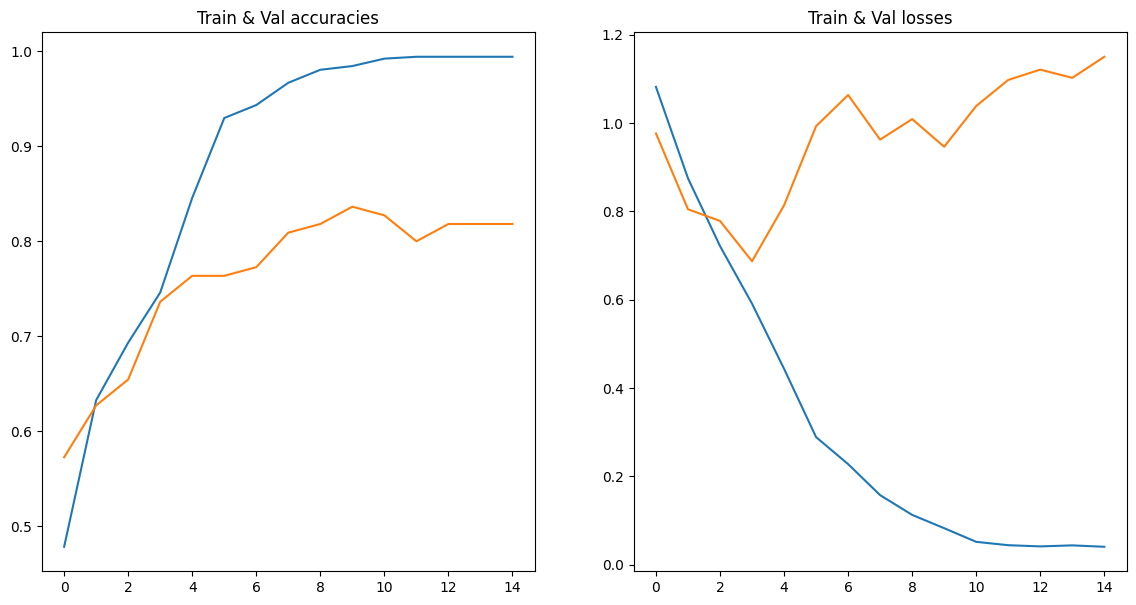

In [63]:
import matplotlib.pyplot as plt


figure, axis = plt.subplots(1, 2, figsize=(14, 7))

axis[0].plot(c_train_acc)
axis[0].plot(c_val_acc)
axis[0].set_title("Train & Val accuracies")

axis[1].plot(c_train_losses)
axis[1].plot(c_val_losses)
axis[1].set_title("Train & Val losses")

plt.show()

In [64]:
# If we take a look at the values train/val, it makes sense for the above graph.
print(f'Train accuracy:\n{c_train_acc}\n\nValidation accuracy:\n{c_val_acc}\n\n\n')
print(f'Train losses:\n{c_train_losses}\n\nValidation accuracy:\n{c_val_losses}')

Train accuracy:
[0.478515625, 0.6328125, 0.693359375, 0.74609375, 0.845703125, 0.9296875, 0.943359375, 0.966796875, 0.98046875, 0.984375, 0.9921875, 0.994140625, 0.994140625, 0.994140625, 0.994140625]

Validation accuracy:
[0.5727272727272728, 0.6272727272727272, 0.6545454545454545, 0.7363636363636363, 0.7636363636363636, 0.7636363636363636, 0.7727272727272727, 0.8090909090909091, 0.8181818181818181, 0.8363636363636363, 0.8272727272727273, 0.7999999999999999, 0.8181818181818181, 0.8181818181818181, 0.8181818181818181]



Train losses:
[1.082006299868226, 0.875068876426667, 0.7215513209812343, 0.5910083055496216, 0.443539905565558, 0.28873237897641957, 0.2276087258651387, 0.15727840471663512, 0.11256591702112928, 0.08241688828638871, 0.051508336187907844, 0.04390748590049043, 0.04117594582567108, 0.043514249662621296, 0.040335727793717524]

Validation accuracy:
[0.9766056495053428, 0.8048281030995506, 0.7784332547869001, 0.6871621385216713, 0.8137275994356189, 0.9930773011541792, 1.0636

# 8) Predictions

In [65]:
# There still is a test dataset and test dataloader to use. Show their data again.
for i, x in enumerate(test_ds):
    text = x['text']
    label = x['label'].item()
    print(f'---Index {i}---\nText:\n{text}\nLabel: {label}\n\n')
    
    # Only print a few
    if i >= 2:
        break
        
# Print the head to see the above matches 
test_df.head()

---Index 0---
Text:
Melancholy painting the world in hues of nostalgia, a canvas of bittersweet memories.
Label: 1


---Index 1---
Text:
Missing an important event due to unforeseen circumstances. A day filled with sadness.
Label: 1


---Index 2---
Text:
Whimsical delight in a world of whimsical fairy tales.
Label: 2




,Text,Sentiment
229,Melancholy painting the world in hues of nosta...,1
693,Missing an important event due to unforeseen c...,1
396,Whimsical delight in a world of whimsical fair...,2
393,Exploring the universe within during a mindful...,2
704,Trying out a new study technique for upcoming ...,2


In [66]:
# Load up the best model before using predictions
model.load_state_dict(torch.load('best_model_found.bin'))

# Of course place it on proper device. If gpu is being used, continue to use it.
model = model.to(device)

In [67]:
''' I've displayed usage of the test dataset above but really the test_dl will be used
    because it contains the actual values to pass TO the model. It has: "text", "input_ids"
    (which is the text in numerical form), "attention_mask", and "label". Also this
    is in batches.
    
    Also remember the labels were turned into numerical form thanks to the dictionary:
    "num_sentiments = {
        "Positive": 0,
        "Negative": 1,
        "Neutral": 2
    }" So invert that to see the words again.
    
    "batch" will be a small example for the predict function to see how the model does
    with a small portion. Remember it has text, input_ids, attention_mask and label.
    
    '''

sentiments = {value:key for key, value in num_sentiments.items()}

batch = None
for x in test_dl:
    batch = x
    break

print(f'Reversed sentiment dictionary:\n{sentiments}\n\nExample batch:\n{batch}')

Reversed sentiment dictionary:
{0: 'Positive', 1: 'Negative', 2: 'Neutral'}

Example batch:
{'text': ['Hopeful whispers of wind, carrying the promises of a brighter tomorrow, a symphony of optimism in the air of possibilities.', 'Fuming with anger after a heated argument.', 'Enjoying a cup of tea and watching the sunset.', 'Spent hours perfecting a chemistry experiment. Mixing potions like a wizard!', 'Wandering through the cemetery of lost dreams, tombstones marking untold sorrows.', 'Boredom sets in, the day feels endlessly dull.', 'Feeling grateful for the little things in life.', 'Charting a course through the waves of hopeful anticipation, a sailor steering towards the shores of dreams yet unexplored.'], 'input_ids': tensor([[  101,  5977,  2365, 11668,  1104,  3223,   117,  4004,  1103, 11323,
          1104,   170, 18044,  4911,   117,   170, 19395,  1104, 11769,  3121,
         20279,  1107,  1103,  1586,  1104, 12435,   119,   102,     0,     0,
             0,     0,     0,  

In [68]:
def predict(cur_batch):
    # Batch sizes are 8. So ids, masks, and labels are 8 in length.
    input_ids = cur_batch['input_ids'].to(device)
    attention_mask = cur_batch['attention_mask'].to(device)
    labels = cur_batch['label'].to(device)
        
    ''' Raw model prediction. Returns 2d matrix like: 
        "tensor([[ 6.1035, -3.5364, -2.1272],
                 [ 6.4079, -3.7241, -2.4979],
                 [ 6.5357, -3.6224, -2.9600],
                 [ 5.6578, -3.7985, -1.6548],
                 [-3.1863,  6.0528, -1.7894],
                 [ 6.1287, -3.8653, -2.2358],
                 [ 4.1773, -4.0353, -0.2256],
                 [ 6.0674, -3.5623, -2.2453]], device='cuda:0',
       grad_fn=<AddmmBackward0>)"
    
        As said before, the torch.max will go row by row and get index of highest
        value. For above matrix, it'll give indices [0,0,0,0,1,0,0,0]
    
    '''
    results = model(input_ids, attention_mask)
    values, predictions = torch.max(results, dim=1)
    total = torch.sum(predictions == labels)
    
    print(f'Raw model outputs:\n{results}\n\n')
    print(f'Predictions (selected indices from above matrix):\n{predictions})\n\n')
    print(f'{total}/{len(input_ids)} correct!\n')
    



predict(batch)

Raw model outputs:
tensor([[ 4.3016, -2.6287, -2.1810],
        [-1.7984, -1.2034,  4.7676],
        [ 4.2503, -2.9547, -2.0789],
        [ 4.2299, -3.2252, -1.9162],
        [-3.4237,  4.7764, -1.2025],
        [-3.5344,  4.7258, -1.0447],
        [ 2.7592, -2.9882,  0.9958],
        [ 4.2674, -2.7811, -2.1904]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


Predictions (selected indices from above matrix):
tensor([0, 2, 0, 0, 1, 1, 0, 0], device='cuda:0'))


6/8 correct!



In [69]:
# Predict on entire test data loader. (cur_model, cur_dl, cur_loss_func, cur_device, len_of_df)
acc, loss = evaluate_model(model, test_dl, loss_func, device, len(test_df))

# Not too bad at all accuracy wise.
acc

Evaluating: 100%|██████████| 14/14 [00:00<00:00, 20.52it/s, loss=1.22]


tensor(0.7818, device='cuda:0', dtype=torch.float64)